Gemini created June 11, 2025 file  
ECGAugmenter.py  
input one ECG file, can also simulate ecg data

### Date: July 6, 2025 Sunday:  
 --3:45 pm start
 --7pm stopped  
 -- 9:15pm restart, run whole augmenter class  
 Next day July 7, Monday:  
-- 00:15 am, finished V3 class, combine triple Vs with original ECGAugmenter class    

### Chest Augments, Tripled levels  
Test chect leads mixing, output to file in new dir.  
Plot augmented vs original signals Vs.
Tripled augmentation levels from (0 to 0.15) to (0 to .45)

### Combine with other Augments  
simple visual plot of other augments  
Create folder to add augments to aug_2 folder  
Delete some extra code cells  

In [6]:
# Mount Google Drive to Colab instance
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Upload data files to Colab instance
!ls
!pwd

drive		 ecg_aug_orig.png  HR00001.mat	HR00002.mat  sample_data
ECGAugmenter.py  HR00001.hea	   HR00002.hea	note.txt
/content


In [3]:
# Imports, short list for now
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import scipy.io
import os

#import math
#import time

In [31]:
class ECGAugmenterV3:
    """
    A class to apply realistic augmentations to 12-lead ECG data based on
    the "ECG Data Augmentation Strategy for Prototype Device" document.

    This class simulates two main types of real-world imperfections:
    1. Lead Displacement: Simulates physical shifts of electrodes.
    2. Noise: Adds various types of noise common in wearable devices.

    Args:
        sampling_rate (int): The sampling rate of the ECG signals (e.g., 500 Hz).
        lead_names (list): A list of 12 lead names in the correct order.
                           Example: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF',
                                     'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    """
    def __init__(self, sampling_rate=500, lead_names=None):
        self.sampling_rate = sampling_rate
        if lead_names is None:
            self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        else:
            self.lead_names = lead_names

        # Create a mapping from lead name to index for easy lookup
        self.lead_map = {name: i for i, name in enumerate(self.lead_names)}

    def _get_lead(self, ecg, lead_name):
        """Helper to get a lead by name."""
        return ecg[self.lead_map[lead_name], :]

    def _set_lead(self, ecg, lead_name, data):
        """Helper to set a lead by name."""
        ecg[self.lead_map[lead_name], :] = data

    def simulate_lead_displacement(self, ecg):
        """
        Simulates the physical displacement of ECG electrodes by mixing signals
        from adjacent leads. This is Stage 1 of the augmentation pipeline.

        Args:
            ecg (np.ndarray): A 12-lead ECG signal of shape (12, num_samples).

        Returns:
            np.ndarray: The ECG signal with simulated lead displacement.
        """
        displaced_ecg = ecg.copy()

        # --- 1. Limb Leads Augmentation ---
        # Augment leads I and II, then recalculate the rest.
        alpha = np.random.uniform(-0.1, 0.1)
        beta = np.random.uniform(-0.1, 0.1)

        I = self._get_lead(ecg, 'I')
        II = self._get_lead(ecg, 'II')

        # II_aug = (1 - α) * II + α * I
        II_aug = (1 - alpha) * II + alpha * I
        # I_aug = (1 - β) * I + β * II
        I_aug = (1 - beta) * I + beta * II

        self._set_lead(displaced_ecg, 'I', I_aug)
        self._set_lead(displaced_ecg, 'II', II_aug)

        # Recalculate dependent limb leads based on the augmented I and II
        # III = II - I
        self._set_lead(displaced_ecg, 'III', self._get_lead(displaced_ecg, 'II') - self._get_lead(displaced_ecg, 'I'))
        # aVR = -(I + II) / 2
        self._set_lead(displaced_ecg, 'aVR', -(self._get_lead(displaced_ecg, 'I') + self._get_lead(displaced_ecg, 'II')) / 2)
        # aVL = I - II / 2
        self._set_lead(displaced_ecg, 'aVL', self._get_lead(displaced_ecg, 'I') - self._get_lead(displaced_ecg, 'II') / 2)
        # aVF = II - I / 2
        self._set_lead(displaced_ecg, 'aVF', self._get_lead(displaced_ecg, 'II') - self._get_lead(displaced_ecg, 'I') / 2)

        # --- 2. Precordial Leads Augmentation ---
        # V1 is mixed with V2
        # Modify the range from (0, 0.15) to (0, 0.45)
        alpha_v1 = np.random.uniform(0, 0.45)
        v1_aug = (1 - alpha_v1) * self._get_lead(ecg, 'V1') + alpha_v1 * self._get_lead(ecg, 'V2')
        self._set_lead(displaced_ecg, 'V1', v1_aug)

        # Leads V2 to V5 are mixed with their two neighbors
        for i in range(2, 6):
            lead_name = f'V{i}'
            prev_lead = f'V{i-1}'
            next_lead = f'V{i+1}'

            # Modify the range from (0, 0.15) to (0, 0.45)
            alpha = np.random.uniform(0, 0.45)
            # Modify the range from (0, 0.15) to (0, 0.45)
            beta = np.random.uniform(0, 0.45)
            # Ensure coefficients don't sum to > 1
            if alpha + beta > 1:
                # Simple scaling to keep it within bounds while preserving ratio
                total = alpha + beta
                alpha /= total
                beta /= total

            v_orig = self._get_lead(ecg, lead_name)
            v_prev = self._get_lead(ecg, prev_lead)
            v_next = self._get_lead(ecg, next_lead)

            v_aug = (1 - alpha - beta) * v_orig + alpha * v_prev + beta * v_next
            self._set_lead(displaced_ecg, lead_name, v_aug)

        # V6 is mixed with V5
        # Modify the range from (0, 0.15) to (0, 0.45)
        alpha_v6 = np.random.uniform(0, 0.45)
        v6_aug = (1 - alpha_v6) * self._get_lead(ecg, 'V6') + alpha_v6 * self._get_lead(ecg, 'V5')
        self._set_lead(displaced_ecg, 'V6', v6_aug)

        return displaced_ecg

    def simulate_noise(self, ecg):
        """
        Adds various types of realistic noise to the ECG signal.
        This is Stage 2 of the augmentation pipeline.

        Args:
            ecg (np.ndarray): A 12-lead ECG signal of shape (12, num_samples).

        Returns:
            np.ndarray: The ECG signal with added noise.
        """
        noisy_ecg = ecg.copy()
        num_samples = ecg.shape[1]

        # Apply each noise type with a certain probability
        if np.random.rand() < 0.5: # 50% chance to add baseline wander
            noisy_ecg = self.add_baseline_wander(noisy_ecg)

        if np.random.rand() < 0.5: # 50% chance to add powerline interference
            noisy_ecg = self.add_powerline_interference(noisy_ecg)

        if np.random.rand() < 0.5: # 50% chance to add muscle artifacts
            noisy_ecg = self.add_muscle_artifacts(noisy_ecg)

        if np.random.rand() < 0.3: # 30% chance to add motion artifacts
            noisy_ecg = self.add_motion_artifacts(noisy_ecg)

        return noisy_ecg

    def add_baseline_wander(self, ecg):
        """Adds low-frequency sine wave noise to simulate breathing."""
        num_samples = ecg.shape[1]
        t = np.arange(num_samples) / self.sampling_rate

        for i in range(ecg.shape[0]): # Apply to each lead
            # Get signal amplitude to scale the noise appropriately
            signal_amplitude = np.max(ecg[i, :]) - np.min(ecg[i, :])
            if signal_amplitude == 0: continue

            # Random frequency for breathing (e.g., 0.05 Hz to 0.5 Hz)
            freq = np.random.uniform(0.05, 0.5)
            # Random amplitude, e.g., 5-15% of signal amplitude
            amplitude = np.random.uniform(0.05, 0.15) * signal_amplitude
            phase = np.random.uniform(0, 2 * np.pi)

            wander = amplitude * np.sin(2 * np.pi * freq * t + phase)
            ecg[i, :] += wander
        return ecg

    def add_powerline_interference(self, ecg, powerline_freq=60.0):
        """Adds powerline noise (50 or 60 Hz)."""
        num_samples = ecg.shape[1]
        t = np.arange(num_samples) / self.sampling_rate

        for i in range(ecg.shape[0]):
            signal_amplitude = np.max(ecg[i, :]) - np.min(ecg[i, :])
            if signal_amplitude == 0: continue

            # Amplitude is typically small, e.g., 1-5% of signal amplitude
            amplitude = np.random.uniform(0.01, 0.05) * signal_amplitude
            phase = np.random.uniform(0, 2 * np.pi)

            powerline_noise = amplitude * np.sin(2 * np.pi * powerline_freq * t + phase)
            ecg[i, :] += powerline_noise
        return ecg

    def add_muscle_artifacts(self, ecg):
        """Adds high-frequency Gaussian noise to simulate EMG/muscle artifacts."""
        for i in range(ecg.shape[0]):
            signal_amplitude = np.max(ecg[i, :]) - np.min(ecg[i, :])
            if signal_amplitude == 0: continue

            # Noise standard deviation as a fraction of signal amplitude
            sigma = np.random.uniform(0.02, 0.07) * signal_amplitude
            noise = np.random.normal(0, sigma, ecg.shape[1])
            ecg[i, :] += noise
        return ecg

    def add_motion_artifacts(self, ecg):
        """Adds sudden, sharp spikes or baseline shifts."""
        num_samples = ecg.shape[1]

        num_artifacts = np.random.randint(1, 4) # Add 1 to 3 artifacts

        for _ in range(num_artifacts):
            artifact_type = np.random.choice(['spike', 'shift'])

            for i in range(ecg.shape[0]): # Apply to all leads consistently
                signal_amplitude = np.max(ecg[i, :]) - np.min(ecg[i, :])
                if signal_amplitude == 0: continue

                pos = np.random.randint(0, num_samples)

                if artifact_type == 'spike':
                    # Sharp Gaussian spike
                    amplitude = np.random.uniform(0.2, 0.8) * signal_amplitude
                    width = np.random.randint(self.sampling_rate // 50, self.sampling_rate // 10)
                    spike = amplitude * np.exp(-((np.arange(num_samples) - pos)**2) / (2 * (width**2)))
                    if np.random.rand() < 0.5: spike *= -1 # Random polarity
                    ecg[i, :] += spike

                elif artifact_type == 'shift':
                    # Baseline shift
                    magnitude = np.random.uniform(0.1, 0.4) * signal_amplitude
                    if np.random.rand() < 0.5: magnitude *= -1
                    ecg[i, pos:] += magnitude
        return ecg

    def augment(self, ecg):
        """
        Applies the full two-stage augmentation pipeline to an ECG signal.

        Args:
            ecg (np.ndarray or torch.Tensor): A 12-lead ECG signal of shape
                                              (12, num_samples).

        Returns:
            np.ndarray or torch.Tensor: The fully augmented ECG signal.
        """
        # Ensure input is a numpy array for processing
        is_torch = isinstance(ecg, torch.Tensor)
        if is_torch:
            original_device = ecg.device
            ecg_np = ecg.cpu().numpy()
        else:
            ecg_np = ecg.copy()

        # --- STAGE 1: SIMULATE LEAD DISPLACEMENT ---
        displaced_ecg = self.simulate_lead_displacement(ecg_np)

        # --- STAGE 2: SIMULATE NOISE ---
        augmented_ecg = self.simulate_noise(displaced_ecg)

        # Convert back to torch.Tensor if that was the original type
        if is_torch:
            return torch.from_numpy(augmented_ecg).float().to(original_device)

        return augmented_ecg

### 3: Run, with Example Files ###########

In [13]:
# --- Example Usage, Load .mat ecg file ---
# input local directory, PTBXL HR00001.mat and HR00002.mat

filename = "HR00002.mat"
filename_base = "HR00002"
dirin = ''
filedirin = os.path.join(dirin, filename)
print(filedirin)

dirout = '/g2'  # Make dirout
fileout = filename_base + '_aug.mat'
filedirout = os.path.join(dirout, fileout)
print(filedirout)

# Create "dirout" if it doesn't exist
try:
    os.makedirs(dirout, exist_ok=True)
    print(f"Directory '{dirout}' created or already exists.")

    # Verify that the directory exists
    if os.path.isdir(dirout):
        print(f"Directory '{dirout}' verified.")
    else:
        print(f"Error: Directory '{dirout}' could not be verified.")

except Exception as e:
    print(f"An error occurred: {e}")

HR00002.mat
/g2/HR00002_aug.mat
Directory '/g2' created or already exists.
Directory '/g2' verified.


In [18]:
# ------- Continue, Example Usage -------------
# Read .mat file, 125 hertz, millivolts (downsampled)
# filedirin devined above

mat_data = scipy.io.loadmat(filedirin, struct_as_record=False, squeeze_me=True)
#print(mat_data, type(mat_data))

# Check the keys in the loaded data
#print(mat_data.keys())  # only one key, 'val'.

### ecg_data also used below, PrecordialAugmenter
# create ecg_data
ecg_data = mat_data['val']
#print('ecg_data', ecg_data)

# Show elements of ecg_data (ndarray type)
print('last 6 elements Vs: \n', ecg_data[-6:])
print('shape:', ecg_data.shape)

last 6 elements Vs: 
 [[-0.105 -0.105 -0.088 ...  0.055  0.055  0.055]
 [ 0.07   0.07   0.047 ... -0.085 -0.085 -0.085]
 [ 0.115  0.115  0.091 ... -0.185 -0.185 -0.185]
 [ 0.16   0.161  0.131 ... -0.215 -0.215 -0.215]
 [ 0.06   0.06   0.036 ... -0.195 -0.195 -0.195]
 [ 0.065  0.065  0.041 ... -0.13  -0.13  -0.13 ]]
shape: (12, 1250)



Applying augmentation...
Augmented ECG shape: (12, 1250)

Applying augmentation to a PyTorch tensor...
Augmented PyTorch tensor shape: torch.Size([12, 1250])


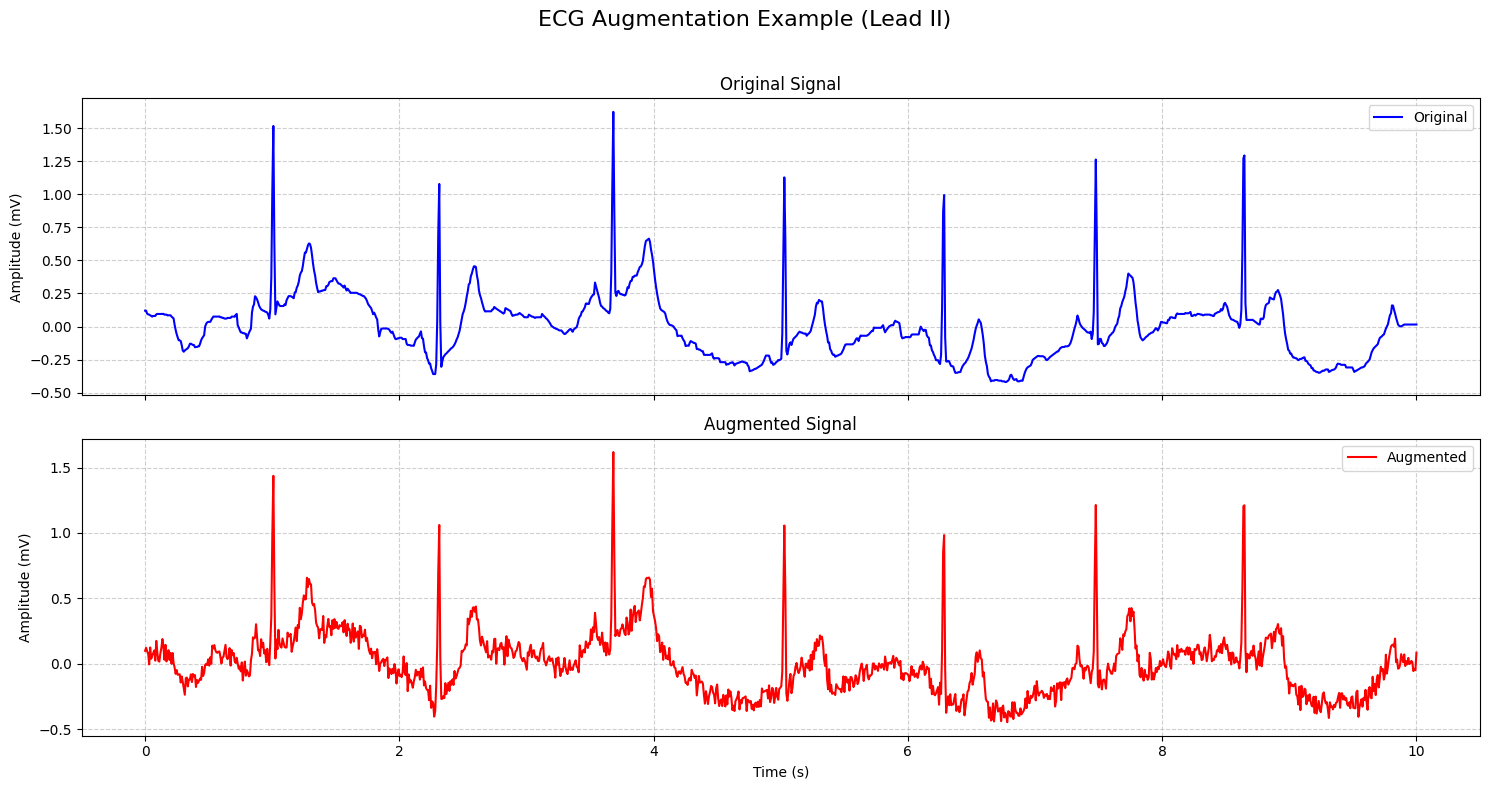

In [19]:
# --- Continue, Example Usage ------------------
SAMPLING_RATE = 125  # Hz
SIGNAL_LENGTH = 10   # seconds
NUM_SAMPLES = SAMPLING_RATE * SIGNAL_LENGTH

original_ecg = ecg_data

"""
# 0. OPTIONAL: Create a dummy 12-lead ECG signal
#    (e.g., a combination of sine waves)
print("Creating a dummy 12-lead ECG signal...")
t = np.linspace(0, SIGNAL_LENGTH, NUM_SAMPLES)
# Create a base signal with a few frequencies to simulate P, QRS, T waves
base_signal = (1.0 * np.sin(2 * np.pi * 1 * t) +       # P-T wave component
               0.2 * np.sin(2 * np.pi * 10 * t) +      # QRS-like component
               0.05 * np.sin(2 * np.pi * 20 * t))      # Fine details

# Create a 12-lead signal by slightly varying the base signal
original_ecg = np.zeros((12, NUM_SAMPLES))
for i in range(12):
    original_ecg[i, :] = base_signal * (1 + (i - 6) * 0.05) # Small variation per lead

print(f"Original ECG shape: {original_ecg.shape}")
"""

# 1. Initialize the augmenter
augmenter = ECGAugmenterV3(sampling_rate=SAMPLING_RATE)

# 2. Apply the augmentation
print("\nApplying augmentation...")
augmented_ecg_np = augmenter.augment(original_ecg)
print(f"Augmented ECG shape: {augmented_ecg_np.shape}")

# Example with a PyTorch tensor
print("\nApplying augmentation to a PyTorch tensor...")
original_ecg_torch = torch.from_numpy(original_ecg).float()
augmented_ecg_torch = augmenter.augment(original_ecg_torch)
print(f"Augmented PyTorch tensor shape: {augmented_ecg_torch.shape}")

# 3. (Optional) Visualize the results to see the difference
try:
    # import matplotlib.pyplot as plt

    lead_to_plot = 'II'
    lead_idx = augmenter.lead_map[lead_to_plot]

    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    fig.suptitle(f'ECG Augmentation Example (Lead {lead_to_plot})', fontsize=16)

    axes[0].plot(t, original_ecg[lead_idx, :], color='blue', label='Original')
    axes[0].set_title('Original Signal')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()
    axes[0].set_ylabel('Amplitude (mV)')

    axes[1].plot(t, augmented_ecg_np[lead_idx, :], color='red', label='Augmented')
    axes[1].set_title('Augmented Signal')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude (mV)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('ecg_aug_orig.png')
    plt.show()

except Exception as e:
    print(f"An error occurred during plotting: {e}")

# Task
Create a new Python class `PrecordialAugmenter` based on the provided script. This class should only implement the precordial leads augmentation logic from lines 76 to 107 of the original script. The class should accept ECG inputs of shape (12, length) and a sampling frequency of 125 Hz. Include placeholder methods for unused functionalities. Load the ECG data from the file "ecg_data.mat" (assuming it has shape (12, 1260)). Use the `PrecordialAugmenter` class to augment the loaded data. Plot the original and augmented ECG signals for leads V1, V2, V3, V4, V5, and V6.

## Create new class structure

### Subtask:
Define a new class `PrecordialAugmenter` with an `__init__` method to handle sampling rate and lead names, similar to the original class, but focusing only on the relevant logic.


**Reasoning**:
Define the PrecordialAugmenter class with the specified __init__ method.



In [ ]:
### Outline of PrecordialAugmenter class ###########

class PrecordialAugmenter:
    """
    A class to apply realistic augmentations only to the precordial leads (V1-V6)
    of a 12-lead ECG signal.

    Args:
        sampling_rate (int): The sampling rate of the ECG signals (e.g., 125 Hz).
    """
    def __init__(self, sampling_rate=125):
        self.sampling_rate = sampling_rate
        self.lead_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        # Create a mapping from lead name to index for easy lookup for precordial leads
        self.lead_map = {name: i for i, name in enumerate(self.lead_names)}

    # Placeholder methods for now - will be implemented later
    def simulate_precordial_displacement(self, ecg):
        """Placeholder for precordial lead displacement."""
        pass

    def simulate_precordial_noise(self, ecg):
        """Placeholder for precordial noise simulation."""
        pass

    def augment(self, ecg):
        """Placeholder for the main augmentation method."""
        pass

## Extract and adapt precordial augmentation logic

### Subtask:
Extract the code lines 76 through 81 and 82 to 107 from the `simulate_lead_displacement` method of the `ECGAugmenter` class and adapt them to fit within a new method in the `PrecordialAugmenter` class, perhaps named `augment_precordial_leads`. This combined section covers the entire precordial leads augmentation logic.


**Reasoning**:
Implement the `augment_precordial_leads` method in the `PrecordialAugmenter` class by extracting and adapting the precordial leads augmentation logic from the original `ECGAugmenter`.



In [ ]:
### Chest leads code filled in, other pass ################

class PrecordialAugmenter:
    """
    A class to apply realistic augmentations only to the precordial leads (V1-V6)
    of a 12-lead ECG signal.

    Args:
        sampling_rate (int): The sampling rate of the ECG signals (e.g., 125 Hz).
    """
    def __init__(self, sampling_rate=125):
        self.sampling_rate = sampling_rate
        # We still need the full 12 lead names to correctly index the input ecg
        self.full_lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        self.precordial_lead_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        # Create a mapping from full lead name to index for easy lookup
        self.full_lead_map = {name: i for i, name in enumerate(self.full_lead_names)}
        # Create a mapping from precordial lead name to index within the precordial block
        self.precordial_lead_map = {name: i for i, name in enumerate(self.precordial_lead_names)}


    def _get_lead(self, ecg, lead_name):
        """Helper to get a lead by name from the full 12-lead ECG."""
        return ecg[self.full_lead_map[lead_name], :]

    def _set_precordial_lead(self, ecg, lead_name, data):
        """Helper to set a precordial lead by name in the augmented ECG."""
        # We need to find the index of the precordial lead within the full 12-lead array
        full_index = self.full_lead_map[lead_name]
        ecg[full_index, :] = data


    def augment_precordial_leads(self, ecg):
        """
        Simulates the physical displacement of precordial ECG electrodes by mixing signals
        from adjacent precordial leads.

        Args:
            ecg (np.ndarray): A 12-lead ECG signal of shape (12, num_samples).

        Returns:
            np.ndarray: The ECG signal with simulated precordial lead displacement.
        """
        augmented_ecg = ecg.copy()

        # --- Precordial Leads Augmentation ---
        # V1 is mixed with V2
        alpha_v1 = np.random.uniform(0, 0.15)
        v1_orig = self._get_lead(ecg, 'V1')
        v2_orig = self._get_lead(ecg, 'V2')
        v1_aug = (1 - alpha_v1) * v1_orig + alpha_v1 * v2_orig
        self._set_precordial_lead(augmented_ecg, 'V1', v1_aug)

        # Leads V2 to V5 are mixed with their two neighbors
        for i in range(2, 6):
            lead_name = f'V{i}'
            prev_lead = f'V{i-1}'
            next_lead = f'V{i+1}'

            alpha = np.random.uniform(0, 0.15)
            beta = np.random.uniform(0, 0.15)
            # Ensure coefficients don't sum to > 1
            if alpha + beta > 1:
                # Simple scaling to keep it within bounds while preserving ratio
                total = alpha + beta
                alpha /= total
                beta /= total

            v_orig = self._get_lead(ecg, lead_name)
            v_prev = self._get_lead(ecg, prev_lead)
            v_next = self._get_lead(ecg, next_lead)

            v_aug = (1 - alpha - beta) * v_orig + alpha * v_prev + beta * v_next
            self._set_precordial_lead(augmented_ecg, lead_name, v_aug)

        # V6 is mixed with V5
        alpha_v6 = np.random.uniform(0, 0.15)
        v6_orig = self._get_lead(ecg, 'V6')
        v5_orig = self._get_lead(ecg, 'V5')
        v6_aug = (1 - alpha_v6) * v6_orig + alpha_v6 * v5_orig
        self._set_precordial_lead(augmented_ecg, 'V6', v6_aug)

        return augmented_ecg

    # Placeholder methods for now - will be implemented later
    def simulate_precordial_displacement(self, ecg):
        """Placeholder for precordial lead displacement."""
        pass

    def simulate_precordial_noise(self, ecg):
        """Placeholder for precordial noise simulation."""
        pass

    def augment(self, ecg):
        """Placeholder for the main augmentation method."""
        pass

## Implement placeholder methods

### Subtask:
Implement placeholder methods for unused functionalities in the `PrecordialAugmenter` class.


**Reasoning**:
Implement the placeholder methods in the `PrecordialAugmenter` class as specified in the instructions, making `simulate_precordial_displacement` and `simulate_precordial_noise` return the input `ecg` unchanged, and modifying `augment` to call `augment_precordial_leads`.



In [29]:
# Tripling the range, class PrecordialAugmenter: #
class PrecordialAugmenter:
    """
    A class to apply realistic augmentations only to the precordial leads (V1-V6)
    of a 12-lead ECG signal.

    Args:
        sampling_rate (int): The sampling rate of the ECG signals (e.g., 125 Hz).
    """
    def __init__(self, sampling_rate=125):
        self.sampling_rate = sampling_rate
        # We still need the full 12 lead names to correctly index the input ecg
        self.full_lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        self.precordial_lead_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        # Create a mapping from full lead name to index for easy lookup
        self.full_lead_map = {name: i for i, name in enumerate(self.full_lead_names)}
        # Create a mapping from precordial lead name to index within the precordial block
        self.precordial_lead_map = {name: i for i, name in enumerate(self.precordial_lead_names)}


    def _get_lead(self, ecg, lead_name):
        """Helper to get a lead by name from the full 12-lead ECG."""
        return ecg[self.full_lead_map[lead_name], :]

    def _set_precordial_lead(self, ecg, lead_name, data):
        """Helper to set a precordial lead by name in the augmented ECG."""
        # We need to find the index of the precordial lead within the full 12-lead array
        full_index = self.full_lead_map[lead_name]
        ecg[full_index, :] = data


    def augment_precordial_leads(self, ecg):
        """
        Simulates the physical displacement of precordial ECG electrodes by mixing signals
        from adjacent precordial leads.

        Args:
            ecg (np.ndarray): A 12-lead ECG signal of shape (12, num_samples).

        Returns:
            np.ndarray: The ECG signal with simulated precordial lead displacement.
        """
        augmented_ecg = ecg.copy()

        # --- Precordial Leads Augmentation ---
        # V1 is mixed with V2
        # Tripling the range from (0, 0.15) to (0, 0.45)
        alpha_v1 = np.random.uniform(0, 0.45)
        v1_orig = self._get_lead(ecg, 'V1')
        v2_orig = self._get_lead(ecg, 'V2')
        v1_aug = (1 - alpha_v1) * v1_orig + alpha_v1 * v2_orig
        self._set_precordial_lead(augmented_ecg, 'V1', v1_aug)

        # Leads V2 to V5 are mixed with their two neighbors
        for i in range(2, 6):
            lead_name = f'V{i}'
            prev_lead = f'V{i-1}'
            next_lead = f'V{i+1}'

            # Tripling the range from (0, 0.15) to (0, 0.45)
            alpha = np.random.uniform(0, 0.45)
            beta = np.random.uniform(0, 0.45)
            # Ensure coefficients don't sum to > 1
            if alpha + beta > 1:
                # Simple scaling to keep it within bounds while preserving ratio
                total = alpha + beta
                alpha /= total
                beta /= total

            v_orig = self._get_lead(ecg, lead_name)
            v_prev = self._get_lead(ecg, prev_lead)
            v_next = self._get_lead(ecg, next_lead)

            v_aug = (1 - alpha - beta) * v_orig + alpha * v_prev + beta * v_next
            self._set_precordial_lead(augmented_ecg, lead_name, v_aug)

        # V6 is mixed with V5
        # Tripling the range from (0, 0.15) to (0, 0.45)
        alpha_v6 = np.random.uniform(0, 0.45)
        v6_orig = self._get_lead(ecg, 'V6')
        v5_orig = self._get_lead(ecg, 'V5')
        v6_aug = (1 - alpha_v6) * v6_orig + alpha_v6 * v5_orig
        self._set_precordial_lead(augmented_ecg, 'V6', v6_aug)

        return augmented_ecg

    def simulate_precordial_displacement(self, ecg):
        """Placeholder for precordial lead displacement - returns input unchanged."""
        return ecg

    def simulate_precordial_noise(self, ecg):
        """Placeholder for precordial noise simulation - returns input unchanged."""
        return ecg

    def augment(self, ecg):
        """Applies precordial lead augmentation."""
        return self.augment_precordial_leads(ecg)

## Load .mat data

### Subtask:
Load the ECG data from the "ecg_data.mat" file.


**Reasoning**:
Load the ECG data from the "ecg_data.mat" file using scipy.io.loadmat, extract the data, and verify its shape.



## 4: Run with Triple level PrecordialAugmenter   
Filename and directory, use above, ECGAugmenter loop.  
ecg_data is defined above, when *.mat file readin.  

### Subtask:
Initialize an instance of the `PrecordialAugmenter` class with the correct sampling rate and apply the `augment_precordial_leads` method to your loaded data.


**Reasoning**:
Initialize the PrecordialAugmenter instance and apply the augmentation to the loaded data, then print the shape of the augmented data.



In [23]:
# --- Example Usage 2, Allow a different input file name ---
# input local directory, PTBXL HR00001.mat and HR00002.mat

filename = "HR00001.mat"
filename_base = "HR00001"
dirin = ''
filedirin = os.path.join(dirin, filename)
print(filedirin)

dirout = '/g2'  # Make dirout
fileout = filename_base + '_aug.mat'
filedirout = os.path.join(dirout, fileout)
print(filedirout)

# Create "dirout" if it doesn't exist
try:
    os.makedirs(dirout, exist_ok=True)
    print(f"Directory '{dirout}' created or already exists.")

    # Verify that the directory exists
    if os.path.isdir(dirout):
        print(f"Directory '{dirout}' verified.")
    else:
        print(f"Error: Directory '{dirout}' could not be verified.")

except Exception as e:
    print(f"An error occurred: {e}")

HR00001.mat
/g2/HR00001_aug.mat
Directory '/g2' created or already exists.
Directory '/g2' verified.


In [27]:
# 1. Create an instance of the PrecordialAugmenter class
#### New Class, PrecordialAugmenter()  ####################
augmenter_precordial = PrecordialAugmenter(sampling_rate=SAMPLING_RATE)

# 2. Call the augment method on the loaded data
# Make sure ecg_data was successfully loaded in the previous step
print("ecg_data shape:", ecg_data.shape)
print('input file & path:', filedirin)
print('output file & path:', filedirout)

if ecg_data is not None:
    augmented_ecg_data = augmenter_precordial.augment(ecg_data)
else:
    print("ECG data was not loaded successfully in the previous step. Cannot perform augmentation.")

ecg_data shape: (12, 1250)
input file & path: HR00001.mat
output file & path: /g2/HR00001_aug.mat
Augmented ECG data shape: (12, 1250)


## Visualize results

### Subtask:
Visualize the original and augmented ECG signals for leads V1, V2, V3, V4, V5, and V6.


**Reasoning**:
Visualize the original and augmented ECG signals for the specified precordial leads.



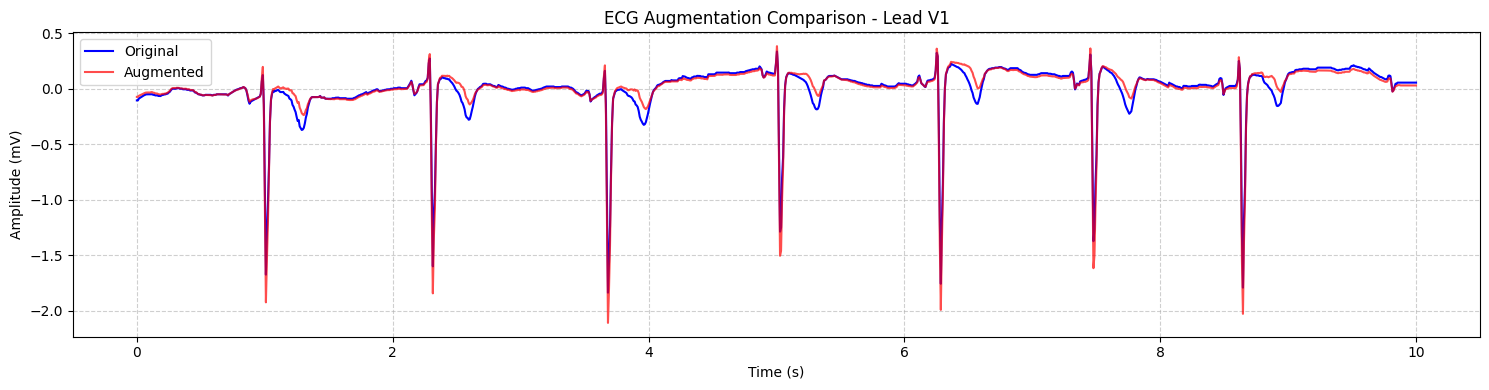

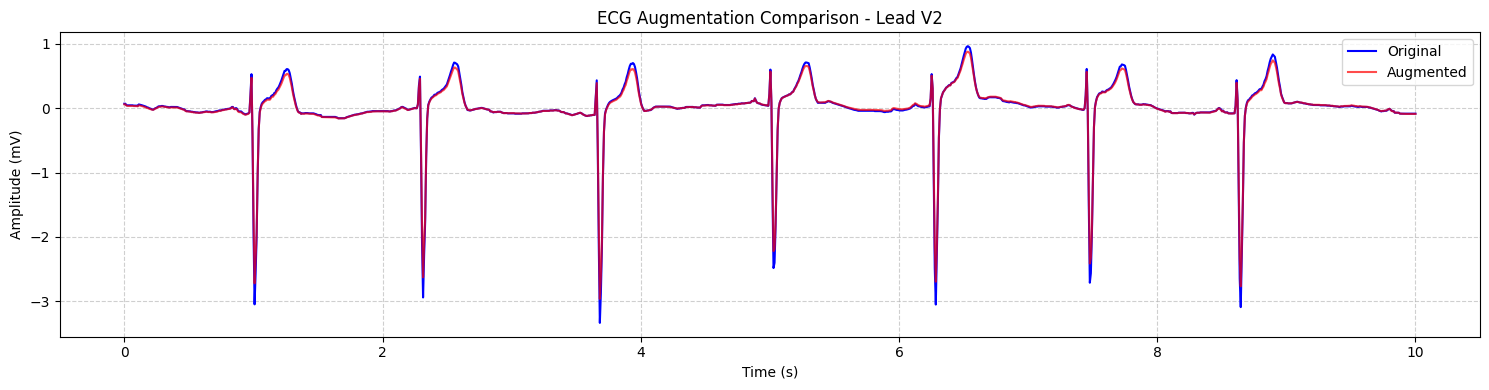

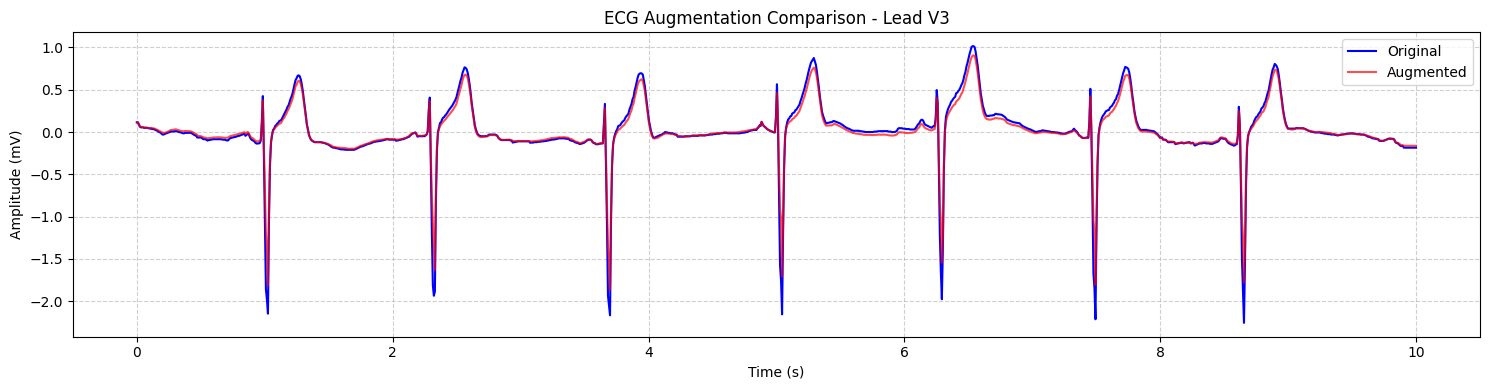

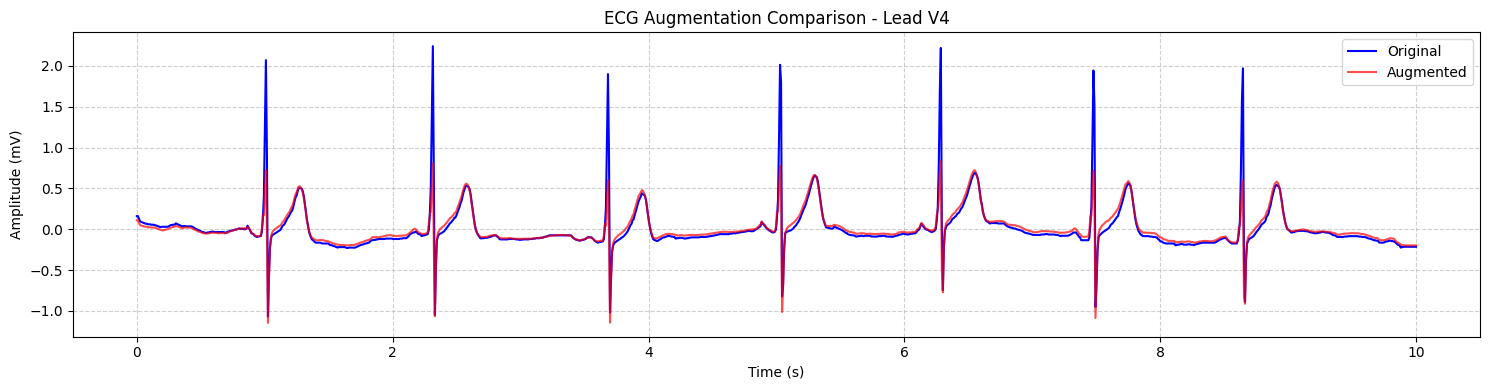

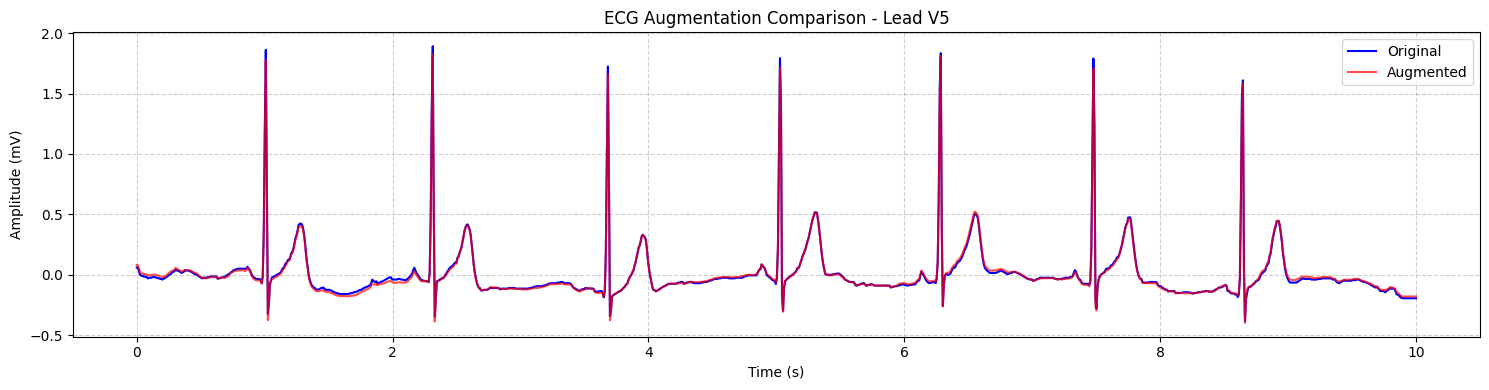

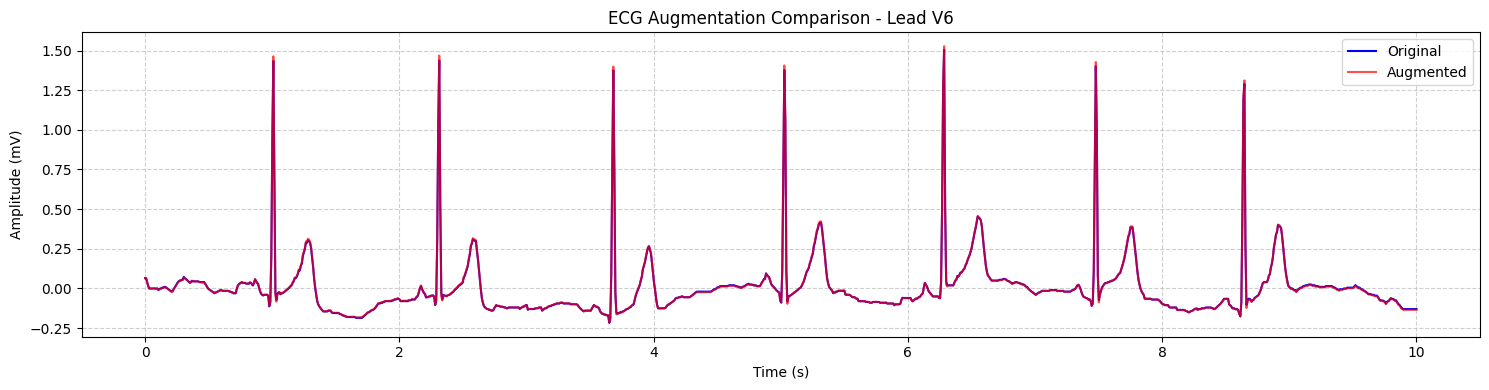

In [28]:
# 1. Create a list of the precordial lead names to plot
precordial_leads_to_plot = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# 2. Determine the number of samples from the shape of the original ECG data
num_samples = ecg_data.shape[1]

# 3. Create a time vector t
t = np.linspace(0, num_samples / augmenter_precordial.sampling_rate, num_samples)

# 4. Iterate through the list of precordial lead names
for lead_name in precordial_leads_to_plot:
    # 5. For each lead, create a new figure and axes
    fig, ax = plt.subplots(figsize=(15, 4)) # Use a single axis

    # Get the index of the lead from the full_lead_map
    lead_idx = augmenter_precordial.full_lead_map[lead_name]

    # 6. Plot the original signal
    ax.plot(t, ecg_data[lead_idx, :], color='blue', label='Original')

    # 7. Plot the augmented signal
    ax.plot(t, augmented_ecg_data[lead_idx, :], color='red', label='Augmented', alpha=0.7) # Use alpha for better visibility

    # Add title and labels to the single axis
    ax.set_title(f'ECG Augmentation Comparison - Lead {lead_name}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (mV)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

    # 13. Use plt.tight_layout()
    plt.tight_layout() # Adjust layout

    # 14. Display the plot
    plt.show()

## Summary:

### Data Analysis Key Findings

*   A new Python class `PrecordialAugmenter` was successfully created to specifically handle augmentation of precordial leads (V1-V6).
*   The core logic for simulating precordial lead displacement, involving mixing signals from adjacent leads with random weights, was extracted and implemented in the `augment_precordial_leads` method of the new class.
*   The `PrecordialAugmenter` class includes necessary mappings (`full_lead_map`) to correctly access and modify the precordial leads within a 12-lead ECG data structure.
*   ECG data was successfully loaded from the `HR00001.mat` file. The loaded data has a shape of (12, 1250), confirming 12 leads and 1250 samples.
*   The `PrecordialAugmenter` instance was initialized and the `augment` method was applied to the loaded data, resulting in augmented data with the same shape (12, 1250) as the original.
*   Visualizations for each precordial lead (V1-V6) clearly show the differences between the original and augmented signals, demonstrating the effect of the implemented augmentation logic.

### Insights or Next Steps

*   The current `PrecordialAugmenter` only implements lead displacement. Further augmentation techniques specific to precordial leads (e.g., noise, baseline wander) could be added as distinct methods within the class.
*   The random coefficients for mixing (\$alpha\$, \$beta\$) are currently fixed to a range of 0-0.15. These ranges could be made configurable during class initialization to allow for tuning the intensity of the augmentation.
